# Factor Research

$$
R_i - R_f = \alpha + \beta_{m, i} * (R_m - R_f) + \beta_{SMB, i} * f_{SMB} + \beta_{HML, i} * f_{HML} + \beta_{Momentum, i} * f_{Momentum} + \varepsilon
$$

- FF3~5 팩터 데이터와 grouping 데이터 (DAUM sectors, corr clustering)
- 팩터 선형 회귀를 이용한 return decomposition
- grouping data로 group neutralization을 한 다음 각 팩터의 demeaned-beta distribution을 확인

## 0. Import libraries & Data

- KRX 데이터를 바탕으로 생존 편향을 없앤 자체 데이터셋 라이브러리 `korquanttools`를 통해 데이터 생성
- 그 외 데이터는 NAVER/DAUM finance 데이터, 한국은행 데이터 등을 활용

In [61]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

import pickle

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

Data 기간은 아래와 같이 설정

- 추후 beta 계산을 위한 moving window도 설정함

In [4]:
# Global parameters

START = 20140101
END = 20221202

WINDOW = 60 # trading day 기준

In [5]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


### Factor data

#### 팩터 데이터 1: Market Excess Return

사용 데이터:
- 주가 수익률
    - 시가총액 가중을 위해 시가총액 데이터도 필요
- 무위험 수익률

** trading day 기준으로 되어있음

주가 수익률

In [6]:
## stock return
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [7]:
holidays = return_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='trdDd', length=2190, freq=None)

In [8]:
return_df = return_df.loc[tradingdays, :].copy()

In [9]:
return_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.011390,0.000000,0.022936,0.023102,-0.014745,-0.041176,-0.013605,0.015060,-0.024029,0.011839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.022523,0.004484,0.022422,-0.006452,-0.023129,0.024540,-0.013793,0.000000,-0.010994,-0.003158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.003304,0.000000,0.021930,-0.003247,0.012535,0.000000,0.011655,-0.026706,0.041587,0.002160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.005488,-0.002232,0.000000,0.003257,0.016506,-0.004491,0.000000,0.009146,0.047871,0.016095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.032751,0.011186,-0.021459,0.000000,-0.004060,-0.022556,-0.006912,-0.009063,0.015195,-0.002121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,-0.023385,-0.027119,-0.018018,-0.021396,-0.012214,-0.008850,-0.011538,0.000000,-0.013865,-0.005291,...,-0.028302,-0.032258,-0.042697,NaN,0.000000,0.002532,-0.002500,NaN,NaN,NaN
2022-11-29,0.007982,0.034843,0.000000,0.005754,0.013910,0.000000,0.017510,0.000000,0.008787,0.005319,...,-0.019417,-0.066667,-0.022300,0.000000,-0.011601,-0.002525,-0.002506,-0.070081,NaN,NaN
2022-11-30,0.020362,-0.003367,0.013761,0.052632,0.015244,0.014286,0.000000,0.000000,0.017422,0.007055,...,0.014851,0.000000,0.020408,0.000000,0.009390,0.000000,-0.002513,-0.078261,NaN,NaN


무위험 수익률

In [10]:
## risk free rate
## https://www.index.go.kr/potal/stts/idxMain/selectPoSttsIdxSearch.do?idx_cd=1073

rf_df = pd.read_excel('bok_risk_free_rate.xls', skiprows=2, nrows=7)

In [11]:
rf_df.set_index(keys=rf_df.columns[0], inplace=True)
rf_df.rename_axis(index=None, inplace=True)
rf_df = rf_df.T
rf_df.index = pd.to_datetime(rf_df.index, format='%Y%m월')


In [12]:
rf_df.columns

Index(['국고채 3년(평균)', '국고채 5년(평균)', '국고채 10년(평균)', '회사채 3년(평균)', 'CD 91물(평균)',
       '콜금리(1일물,평균)', '기준금리'],
      dtype='object')

risk-free rate는 한국은행 10년물 연이율을 일별로 환산하여 사용

In [13]:
rf_df = pd.DataFrame(rf_df[rf_df.columns[2]])
rf_df = rf_df.rename(columns={rf_df.columns[0]: 'bok_10y'})

In [14]:
rf_df

,bok_10y
2014-01-01,3.65
2014-02-01,3.52
2014-03-01,3.54
2014-04-01,3.54
2014-05-01,3.40
...,...
2022-06-01,3.64
2022-07-01,3.30
2022-08-01,3.32
2022-09-01,3.90


#### 팩터 데이터 2: SMB (Small Minus Big)

사용 데이터:
- 시가총액 데이터

In [15]:
# Data for 2nd Factor: SMB (Small Minus Big)

marcap_df = pricevolume.get_data("marketcap")

In [16]:
marcap_df = marcap_df.astype(float) # object로 되어있었음

In [17]:
marcap_df = marcap_df.loc[tradingdays, :].copy()
marcap_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,1.240157e+11,5.227152e+10,2.778912e+11,1.570596e+12,6.005292e+11,9.912291e+09,1.525406e+12,1.904283e+10,2.035340e+12,2.203634e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1.268089e+11,5.251021e+10,2.841220e+11,1.560464e+12,5.866394e+11,1.015554e+10,1.504366e+12,1.904283e+10,2.013035e+12,2.196548e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,1.272278e+11,5.251021e+10,2.903527e+11,1.555397e+12,5.939928e+11,1.015554e+10,1.521899e+12,1.853426e+10,2.096679e+12,2.201272e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,1.279261e+11,5.239087e+10,2.903527e+11,1.560464e+12,6.037974e+11,1.010993e+10,1.521899e+12,1.870378e+10,2.197052e+12,2.236700e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,1.321159e+11,5.298757e+10,2.841220e+11,1.560464e+12,6.013462e+11,9.881885e+09,1.511379e+12,1.853426e+10,2.230509e+12,2.231977e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,2.449590e+11,5.518348e+10,2.988264e+11,4.943871e+12,5.541083e+11,1.702725e+10,1.802434e+12,1.830824e+10,4.166871e+12,6.660502e+10,...,8.442072e+10,1.419905e+11,9.696612e+10,1.128000e+10,6.508100e+09,1.212750e+10,8.079750e+09,7.873522e+10,NaN,NaN
2022-11-29,2.469142e+11,5.710625e+10,2.988264e+11,4.972317e+12,5.618162e+11,1.702725e+10,1.833994e+12,1.830824e+10,4.203487e+12,6.695930e+10,...,8.278148e+10,1.325245e+11,9.480373e+10,1.128000e+10,6.432600e+09,1.209688e+10,8.059500e+09,7.321738e+10,NaN,NaN
2022-11-30,2.519419e+11,5.691397e+10,3.029387e+11,5.234018e+12,5.703804e+11,1.727049e+10,1.833994e+12,1.830824e+10,4.276718e+12,6.743167e+10,...,8.401091e+10,1.325245e+11,9.673850e+10,1.128000e+10,6.493000e+09,1.209688e+10,8.039250e+09,6.748733e+10,NaN,NaN


#### 팩터 데이터 3: HML (High Minus Low)

사용 데이터:
- KRX Funda 데이터 (그 중 PBR)

In [18]:
# Data for 3rd Factor: HML (High Minus Low)

pbr_df = pd.read_pickle('temp_KRX_PBR_20140101_20221202.pkl')
pbr_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.55,0.82,0.41,1.38,0.48,NaN,1.09,NaN,1.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.56,0.83,0.42,1.37,0.47,NaN,1.08,NaN,1.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.56,0.83,0.43,1.37,0.47,NaN,1.09,NaN,1.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.56,0.82,0.43,1.37,0.48,NaN,1.09,NaN,1.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.58,0.83,0.42,1.37,0.48,NaN,1.08,NaN,1.92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,0.70,1.49,0.36,1.97,0.29,NaN,1.64,NaN,2.01,NaN,...,2.78,5.34,2.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-29,0.71,1.54,0.36,1.98,0.29,NaN,1.67,NaN,2.03,NaN,...,2.73,4.99,2.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30,0.72,1.54,0.37,2.08,0.29,NaN,1.67,NaN,2.06,NaN,...,2.77,4.99,2.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 팩터 데이터 4: Momentum

사용 데이터:
- 주가 수익률

In [19]:
return_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.011390,0.000000,0.022936,0.023102,-0.014745,-0.041176,-0.013605,0.015060,-0.024029,0.011839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.022523,0.004484,0.022422,-0.006452,-0.023129,0.024540,-0.013793,0.000000,-0.010994,-0.003158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.003304,0.000000,0.021930,-0.003247,0.012535,0.000000,0.011655,-0.026706,0.041587,0.002160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.005488,-0.002232,0.000000,0.003257,0.016506,-0.004491,0.000000,0.009146,0.047871,0.016095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.032751,0.011186,-0.021459,0.000000,-0.004060,-0.022556,-0.006912,-0.009063,0.015195,-0.002121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,-0.023385,-0.027119,-0.018018,-0.021396,-0.012214,-0.008850,-0.011538,0.000000,-0.013865,-0.005291,...,-0.028302,-0.032258,-0.042697,NaN,0.000000,0.002532,-0.002500,NaN,NaN,NaN
2022-11-29,0.007982,0.034843,0.000000,0.005754,0.013910,0.000000,0.017510,0.000000,0.008787,0.005319,...,-0.019417,-0.066667,-0.022300,0.000000,-0.011601,-0.002525,-0.002506,-0.070081,NaN,NaN
2022-11-30,0.020362,-0.003367,0.013761,0.052632,0.015244,0.014286,0.000000,0.000000,0.017422,0.007055,...,0.014851,0.000000,0.020408,0.000000,0.009390,0.000000,-0.002513,-0.078261,NaN,NaN


## 1. Make Factor data

준비된 데이터들을 재료로 factor data를 만든다. 

모든 factor는 time series window를 따로 사용하지 않고 횡단면(cross-sectional) 으로 계산하여 구함. 

### Factor 1: Market Excess Return

$$
... + \beta_{m, i} * (R_m - R_f) + ...
$$

In [20]:
# 시가총액 가중 market return 
marcap_weights = marcap_df.divide(marcap_df.sum(axis=1), axis=0)
Rm = (return_df * marcap_weights).sum(axis=1)

In [21]:
# 한국은행 국채 10년물 금리를 daily interest rate으로 환산 (compound rate)
Rf = rf_df.reindex(Rm.index, method='ffill').squeeze()
Rf = (1 + Rf * 0.01) ** (1/252) - 1

In [22]:
mkt_excess_R = Rm - Rf
mkt_excess_R

trdDd
2014-01-02   -0.020248
2014-01-03   -0.009241
2014-01-06    0.004118
2014-01-07    0.003524
2014-01-08    0.001258
                ...   
2022-11-28   -0.013256
2022-11-29    0.010726
2022-11-30    0.014261
2022-12-01    0.004928
2022-12-02   -0.016618
Length: 2190, dtype: float64

### Factor 2: SMB

$$
... + \beta_{SMB, i} * f_{SMB} + ...
$$

> SMB(Small minus Big): 
>
> the average return on the three small portfolios minus is the average return on the big portfolios

$$
SMB = \dfrac{(Small Value + Small Neutral + Small Growth)}{3} – \dfrac{(Big Value +
Big Neutral + Big Growth)}{3}
$$

포트폴리오이기 때문에, 마찬가지로 시가총액 가중을 해야한다.

이 때, market 시가총액 weight를 재활용하지 않고, small/big 으로 만들어진 포트폴리오에서 따로 시가총액 weight를 구한다. 

In [23]:
def is_small_size(marcap_row: pd.Series):
    rank_threshold = len(marcap_row[~marcap_row.isna()]) * 1/3
    value_threshold = marcap_row.nsmallest(int(rank_threshold))
    selections = value_threshold.index

    return selections # 오직 small 에 해당하는 종목들의 index만 줌. 
    

In [24]:
def is_big_size(marcap_row: pd.Series):
    rank_threshold = len(marcap_row[~marcap_row.isna()]) * 1/3
    value_threshold = marcap_row.nlargest(int(rank_threshold))
    selections = value_threshold.index

    return selections
    

In [25]:
# index를 각 row에 넣어야 안해당 하는 것은 Nan으로 표시된 채로 DataFrame이 완성됨.
small_size_marcap_df = marcap_df.apply((lambda row: row[is_small_size(row)]), axis=1) 

# small 에 해당하는 marcap만 모아 이 포트폴리오에 맞는 weight를 계산
small_size_marcap_weights = small_size_marcap_df.divide(small_size_marcap_df.sum(axis=1), axis=0)

# 이미 구해놓은 mask를 통해 쉽게 return을 구함. 
small_size_returns = return_df[~small_size_marcap_df.isnull()]

In [26]:
small_size_portfolio_returns = (small_size_marcap_weights * small_size_returns).sum(axis=1)
small_size_portfolio_returns

trdDd
2014-01-02   -0.003392
2014-01-03    0.000529
2014-01-06    0.005350
2014-01-07    0.006058
2014-01-08    0.005170
                ...   
2022-11-28   -0.016115
2022-11-29    0.007370
2022-11-30    0.006492
2022-12-01    0.013234
2022-12-02   -0.000158
Length: 2190, dtype: float64

<AxesSubplot: >

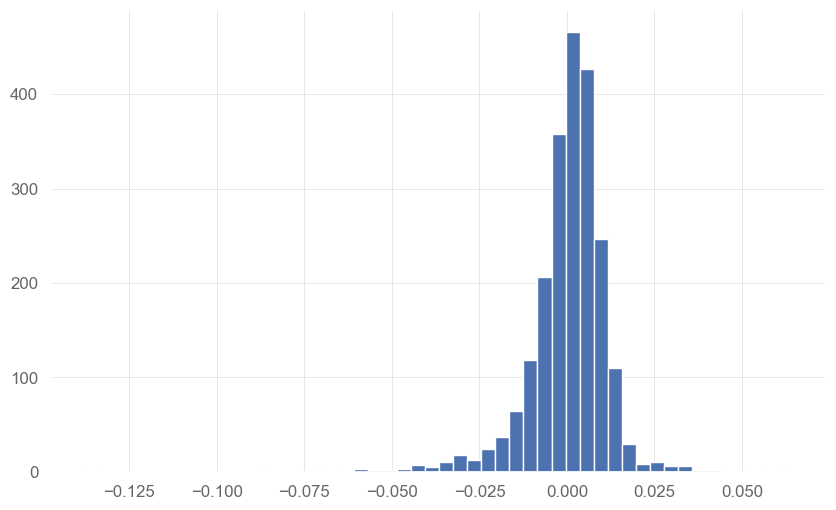

In [27]:
small_size_portfolio_returns.hist(bins=50)

In [28]:
scipy.stats.describe(small_size_portfolio_returns)

DescribeResult(nobs=2190, minmax=(-0.13716054578840597, 0.06400012942283465), mean=0.00021635438023860466, variance=0.00013191571323908658, skewness=-1.9048937288066528, kurtosis=15.743147398545151)

small cap일수록 negatively skewed 된 모습을 보여, abnormal return을 보여준다. 

In [29]:
small_size_portfolio_returns.describe()

count    2190.000000
mean        0.000216
std         0.011485
min        -0.137161
25%        -0.003977
50%         0.001415
75%         0.006204
max         0.064000
dtype: float64

In [30]:
big_size_marcap_df = marcap_df.apply((lambda row: row[is_big_size(row)]), axis=1)
big_size_marcap_weights = big_size_marcap_df.divide(big_size_marcap_df.sum(axis=1), axis=0)
big_size_returns = return_df[~big_size_marcap_df.isnull()]

In [31]:
big_size_portfolio_returns = (big_size_marcap_weights * big_size_returns).sum(axis=1)
big_size_portfolio_returns

trdDd
2014-01-02   -0.020865
2014-01-03   -0.009691
2014-01-06    0.004223
2014-01-07    0.003466
2014-01-08    0.001330
                ...   
2022-11-28   -0.012914
2022-11-29    0.010978
2022-11-30    0.014983
2022-12-01    0.004554
2022-12-02   -0.017656
Length: 2190, dtype: float64

<AxesSubplot: >

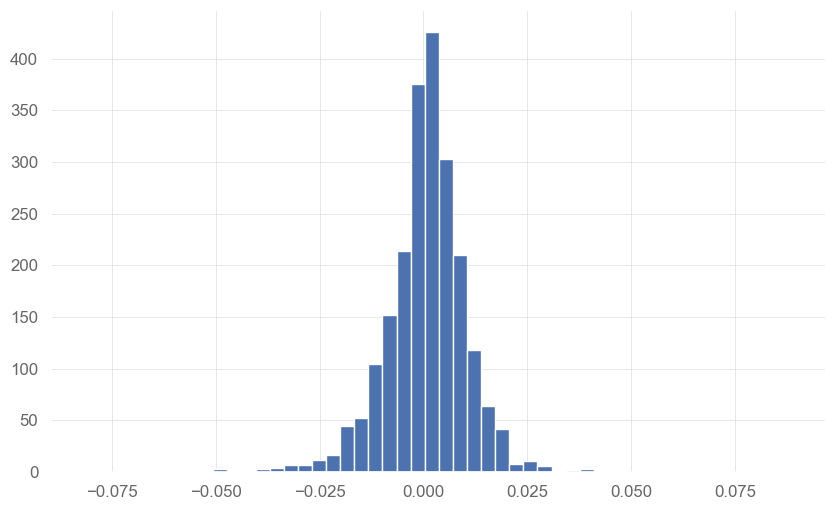

In [32]:
big_size_portfolio_returns.hist(bins=50)

In [33]:
scipy.stats.describe(big_size_portfolio_returns)

DescribeResult(nobs=2190, minmax=(-0.0811453516806436, 0.08858675544586847), mean=0.0006650930213027979, variance=0.00010354533173340495, skewness=-0.03849319537312415, kurtosis=8.398571632681508)

In [34]:
big_size_portfolio_returns.describe()

count    2190.000000
mean        0.000665
std         0.010176
min        -0.081145
25%        -0.004027
50%         0.001038
75%         0.006006
max         0.088587
dtype: float64

In [35]:
SMB = small_size_portfolio_returns - big_size_portfolio_returns
SMB

trdDd
2014-01-02    0.017473
2014-01-03    0.010219
2014-01-06    0.001127
2014-01-07    0.002592
2014-01-08    0.003840
                ...   
2022-11-28   -0.003201
2022-11-29   -0.003608
2022-11-30   -0.008492
2022-12-01    0.008681
2022-12-02    0.017498
Length: 2190, dtype: float64

### Factor 3: HML

$$
... + \beta_{HML, i} * f_{HML} + ...
$$

> HML(High minus Low): 
> 
> the average return on the two value portfolios minus is the average return on the two growth portfolios

$$
SMB = \dfrac{(Small Value + Big Value)}{2} – \dfrac{(Small Growth + Big Growth)}{2}
$$

$Book\text{-}to\text{-}Market \ ratio = \dfrac{장부가}{시가}$

$PBR(Price\text{-}to\text{-}Book \ ratio) = \dfrac{주가}{1 \ 주당 \ 장부가} = \dfrac{시가}{장부가}$

위의 공식에 따라 growth stock 일수록 PBR이 높고, value stock 일수록 PBR이 낮다. 

원래는 Book-to-Market ratio에 기초하기 때문에 High는 value, Low는 growth를 나타낸다는 점을 참고

In [36]:
def is_value(pbr_row: pd.Series): # = High = low PBR
    rank_threshold = len(pbr_row[~pbr_row.isna()]) * 1/2
    value_threshold = pbr_row.nsmallest(int(rank_threshold))
    selections = value_threshold.index

    return selections # 오직 high 에 해당하는 종목들의 index만 줌. 
    

In [37]:
def is_growth(pbr_row: pd.Series): # = Low = high PBR
    rank_threshold = len(pbr_row[~pbr_row.isna()]) * 1/2
    value_threshold = pbr_row.nlargest(int(rank_threshold))
    selections = value_threshold.index

    return selections
    

In [38]:
value_df = pbr_df.apply((lambda row: row[is_value(row)]), axis=1) 
value_marcap_df = marcap_df[~value_df.isnull()]
value_marcap_weights = value_marcap_df.divide(value_marcap_df.sum(axis=1), axis=0)
value_returns = return_df[~value_df.isnull()]

In [39]:
value_portfolio_returns = (value_marcap_weights * value_returns).sum(axis=1)
value_portfolio_returns


trdDd
2014-01-02   -0.012004
2014-01-03   -0.011556
2014-01-06    0.001473
2014-01-07    0.002326
2014-01-08   -0.000182
                ...   
2022-11-28   -0.009389
2022-11-29    0.013425
2022-11-30    0.011539
2022-12-01    0.004235
2022-12-02   -0.015233
Length: 2190, dtype: float64

<AxesSubplot: >

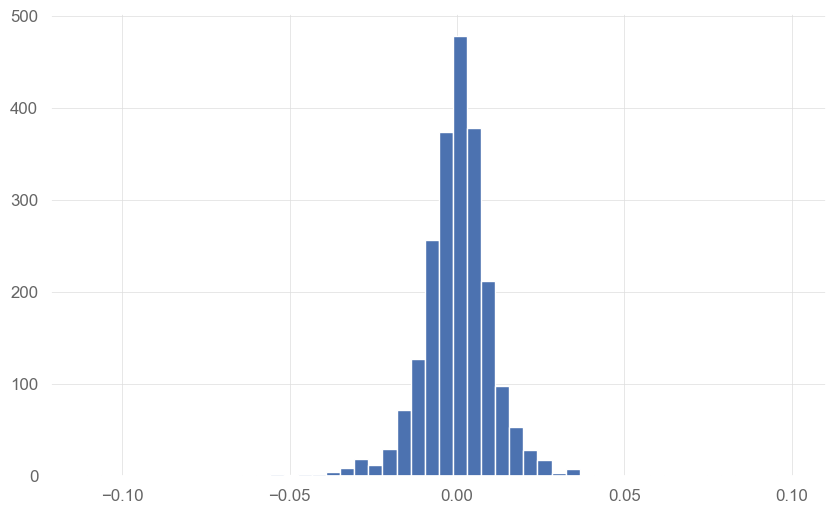

In [40]:
value_portfolio_returns.hist(bins=50)

In [41]:
scipy.stats.describe(value_portfolio_returns)

DescribeResult(nobs=2190, minmax=(-0.11067825392216624, 0.09982351657867197), mean=8.323517374165457e-05, variance=0.00012031029201848573, skewness=-0.22489624910452657, kurtosis=12.652415473386855)

In [42]:
value_portfolio_returns.describe()

count    2190.000000
mean        0.000083
std         0.010969
min        -0.110678
25%        -0.005294
50%         0.000457
75%         0.005637
max         0.099824
dtype: float64

In [43]:
growth_df = pbr_df.apply((lambda row: row[is_growth(row)]), axis=1) 
growth_marcap_df = marcap_df[~growth_df.isnull()]
growth_marcap_weights = growth_marcap_df.divide(growth_marcap_df.sum(axis=1), axis=0)
growth_returns = return_df[~growth_df.isnull()]

In [44]:
growth_portfolio_returns = (growth_marcap_weights * growth_returns).sum(axis=1)
growth_portfolio_returns


trdDd
2014-01-02   -0.024858
2014-01-03   -0.007287
2014-01-06    0.005926
2014-01-07    0.004374
2014-01-08    0.001553
                ...   
2022-11-28   -0.015507
2022-11-29    0.009940
2022-11-30    0.016157
2022-12-01    0.005577
2022-12-02   -0.017693
Length: 2190, dtype: float64

<AxesSubplot: >

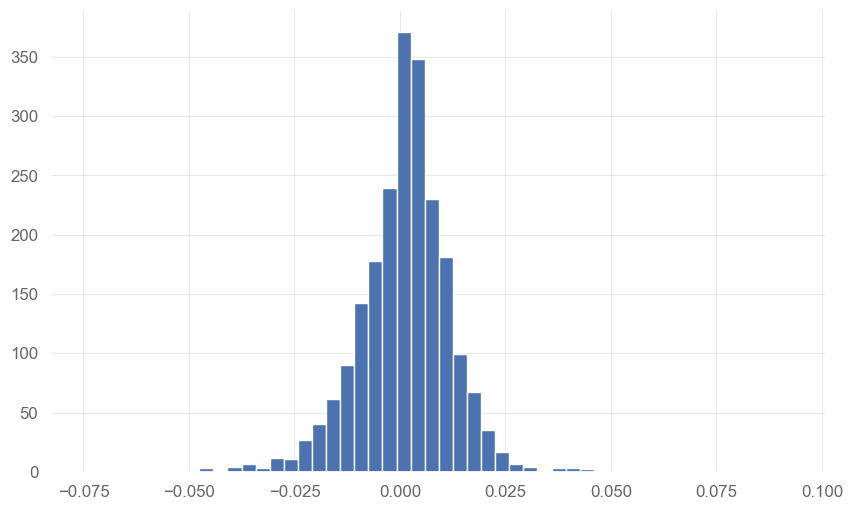

In [45]:
growth_portfolio_returns.hist(bins=50)

In [46]:
scipy.stats.describe(growth_portfolio_returns)

DescribeResult(nobs=2190, minmax=(-0.07425890079825653, 0.09268772994147821), mean=0.0010224634969110398, variance=0.0001231043868365219, skewness=-0.04181911669598458, kurtosis=5.466138491432156)

In [47]:
growth_portfolio_returns.describe()

count    2190.000000
mean        0.001022
std         0.011095
min        -0.074259
25%        -0.004622
50%         0.001601
75%         0.007055
max         0.092688
dtype: float64

In [48]:
HML = value_portfolio_returns - growth_portfolio_returns
HML

trdDd
2014-01-02    0.012854
2014-01-03   -0.004269
2014-01-06   -0.004453
2014-01-07   -0.002049
2014-01-08   -0.001736
                ...   
2022-11-28    0.006118
2022-11-29    0.003486
2022-11-30   -0.004618
2022-12-01   -0.001342
2022-12-02    0.002459
Length: 2190, dtype: float64

### Factor 4: Momentum

$$
... + \beta_{Momentum, i} * f_{Momentum} + ...
$$


** return decomposition 및 factor dashboard 완성하고 추가할 예정 **

## 2. Decompose return into factor returns

각 security의 수익률을 linear regression을 통해 factor로 분해하고, 각 factor의 계수인 beta를 구한다. 

선형회귀를 할 때는 위에서 global 변수로 설정한 `WINDOW`의 기간씩 rolling하며 적용한다. 

따라서 결국 '60일 Beta' 와 같은 계수를 구하게 된다. 

In [52]:
WINDOW

60

In [51]:
return_df.shape

(2190, 3110)

beta를 dataset처럼 생성하려면 

각각의 주식(ii)에 대해 모두 factor decomposition을 위해 linear regression을 하고, 

moving window에 따라 di(기간) 에 대해서도 여러 번 해줘야 하기 때문에 일단 계산량이 많아진다. 

그리고 `WINDOW`를 무작정 키우는 것은 linear factor model이 말 그대로 linear한 관계를 가정하기에 좋지 않을 수 있다. 

그러니까 그냥 최근 `WINDOW`일 만큼만 보자

In [53]:
recent_return_df = return_df.iloc[-WINDOW:, :].copy()

backtest하려는 것이 아니므로 최근 60일 내 전체 값이 존재하지 않는 (nan이 있는) 종목들은 제외하자. 

In [55]:
recent_return_df = recent_return_df.dropna(axis=1, how='any')

In [56]:
recent_return_df.shape

(60, 2632)

In [60]:
recent_mkt_excess_R = mkt_excess_R.iloc[-WINDOW:].copy()
recent_SMB = SMB.iloc[-WINDOW:].copy()
recent_HML = HML.iloc[-WINDOW:].copy()